# Linear regression example

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import time

In [2]:
#Get data from csv file
data = pd.read_csv("LinearExample/insurance.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Check bmi distribution

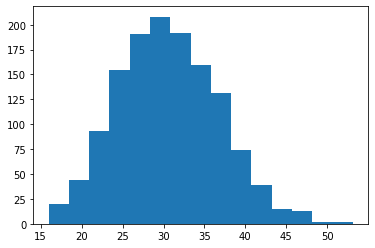

In [3]:
dataNp = data.to_numpy()
bmi = dataNp[:,2]
bmi = bmi.astype('float64')

plt.hist(bmi, bins=15)
plt.show()

### Check charges distribution

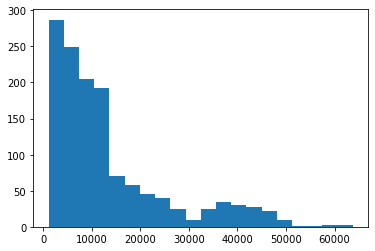

In [4]:
dataNp = data.to_numpy()

age = dataNp[:, 0]
age = age.astype('float64')
sex = dataNp[:, 1]
children = dataNp[:, 3]
charges = dataNp[:, 6]
charges = charges.astype('float64')


plt.hist(charges, bins=20)
plt.show()

### Checking relationship between age and charges

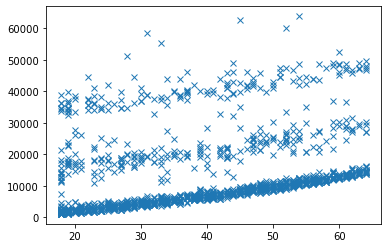

In [5]:
plt.plot(age, charges, 'x');

Checking plot, seems that there is a linear relation between these variables. It's very spreaded though.

Let's try to find a linear equation that fits this data just for fun.

With this visualization, 3 clusters are visible.
How do they relate with other variables?
How can I find the relation between a cluster and another variable(s)?

### Train the model with pytorch

In [6]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
#Get normalize values before spliting sets
ageNorm = np.linalg.norm(age)
chargesNorm = np.linalg.norm(charges)

#divide train and test dataset
X_train, X_test, y_train, y_test = train_test_split(age, charges, train_size=0.65,test_size=0.35)

#Get data sample sizes
trainDataSize = X_train.size
testDataSize = y_test.size

#normalize data
X_train =  X_train / ageNorm
X_test =  X_test / ageNorm
y_train = y_train / chargesNorm
y_test = y_test / chargesNorm

### Plot after normalization

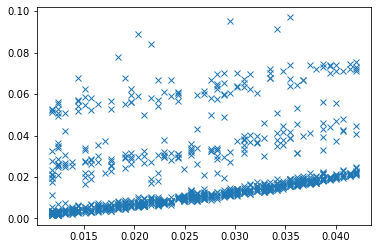

In [8]:
plt.plot(X_train, y_train, 'x');

### Use sklearn to train model and then plot calculated function and train data together

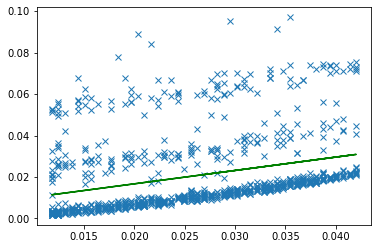

B0: [0.00381401], B1: [0.64505069]


In [9]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

beta0 = linr.intercept_
beta1 = linr.coef_[0]

yplot = X_train * beta1 + beta0

plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot, 'g')
plt.show()

print(f'B0: {beta0}, B1: {beta1}')

### Evaluate model with coeficients provided by sklearn, Plot error distribution

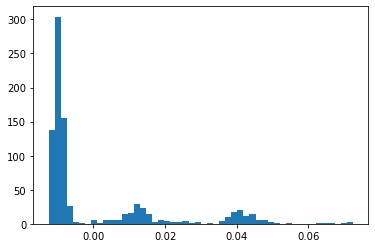

In [10]:
yhat = X_train * beta1 + beta0
error = y_train - yhat

error.size
plt.hist(error, bins=50)
plt.show()

Error distribution shows 3 kernels, leftmost (negative) shows where most of the data is present.

### Use pytorch to train model

In [11]:
n_epochs = 400
batch_size_train = round(trainDataSize / 4)
batch_size_test = testDataSize
learning_rate = 0.1
momentum = 0.5
log_interval = 10

# transform to torch tensor
tensor_train_x = torch.Tensor(X_train.reshape(-1, 1))
tensor_train_y = torch.Tensor(y_train.reshape(-1, 1))

# create your datset
train_data = TensorDataset(tensor_train_x, tensor_train_y)

#Create loader using data
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size_train,
    shuffle=True)

# transform to torch tensor
tensor_test_x = torch.Tensor(X_test.reshape(-1, 1))
tensor_test_y = torch.Tensor(y_test.reshape(-1, 1))

# create your datset
test_data = TensorDataset(tensor_test_x, tensor_test_y)

#Create loader using data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size_test,
    shuffle=True)

In [12]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)
    
#Network model
network = LayerLinearRegression()

#Configure loss function
LossFunction = nn.MSELoss(reduction='mean')

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [13]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [14]:
def train(epoch):
  #Configure network for training
  network.train()

  for batch_idx, (data, target) in enumerate(train_loader):
    
    #set parameters gradients to 0
    optimizer.zero_grad()
    
    #runs model with data and returns result in output
    output = network(data)
    
    #Calculate loss.
    loss = LossFunction(output, target)
    
    #Gradients are calculated
    loss.backward()
    
    #update gradients
    optimizer.step()
    
    #Display iteration statistics
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [15]:
def test():
  #Sets the module in evaluation mode
  network.eval()
  test_loss = 0
  correct = 0
    
  #dont update dynamic computation graph
  with torch.no_grad():
    #for every example in test
    for data, target in test_loader:
      #evaluate the model
      output = network(data)
        
      #acumulate the loss
      test_loss += LossFunction(output, target).item()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      #print('\nTest set: Avg. loss: {:.6f}\n'.format(test_loss))

In [16]:
#Check accuaracy before training
test()
tic = time.perf_counter()

for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
    
toc = time.perf_counter()

print(f"Time elapsed: {toc - tic:0.4f} seconds")

Train Epoch: 1 	Loss: 0.503267
Train Epoch: 2 	Loss: 0.000518
Train Epoch: 3 	Loss: 0.001060
Train Epoch: 4 	Loss: 0.000452
Train Epoch: 5 	Loss: 0.000563
Train Epoch: 6 	Loss: 0.000516
Train Epoch: 7 	Loss: 0.000569
Train Epoch: 8 	Loss: 0.000467
Train Epoch: 9 	Loss: 0.000566
Train Epoch: 10 	Loss: 0.000543
Train Epoch: 11 	Loss: 0.000508
Train Epoch: 12 	Loss: 0.000532
Train Epoch: 13 	Loss: 0.000489
Train Epoch: 14 	Loss: 0.000507
Train Epoch: 15 	Loss: 0.000564
Train Epoch: 16 	Loss: 0.000547
Train Epoch: 17 	Loss: 0.000646
Train Epoch: 18 	Loss: 0.000587
Train Epoch: 19 	Loss: 0.000428
Train Epoch: 20 	Loss: 0.000462
Train Epoch: 21 	Loss: 0.000515
Train Epoch: 22 	Loss: 0.000510
Train Epoch: 23 	Loss: 0.000497
Train Epoch: 24 	Loss: 0.000516
Train Epoch: 25 	Loss: 0.000434
Train Epoch: 26 	Loss: 0.000553
Train Epoch: 27 	Loss: 0.000464
Train Epoch: 28 	Loss: 0.000447
Train Epoch: 29 	Loss: 0.000418
Train Epoch: 30 	Loss: 0.000489
Train Epoch: 31 	Loss: 0.000534
Train Epoch: 32 	

Train Epoch: 254 	Loss: 0.000445
Train Epoch: 255 	Loss: 0.000478
Train Epoch: 256 	Loss: 0.000557
Train Epoch: 257 	Loss: 0.000380
Train Epoch: 258 	Loss: 0.000416
Train Epoch: 259 	Loss: 0.000482
Train Epoch: 260 	Loss: 0.000500
Train Epoch: 261 	Loss: 0.000437
Train Epoch: 262 	Loss: 0.000477
Train Epoch: 263 	Loss: 0.000494
Train Epoch: 264 	Loss: 0.000542
Train Epoch: 265 	Loss: 0.000494
Train Epoch: 266 	Loss: 0.000467
Train Epoch: 267 	Loss: 0.000459
Train Epoch: 268 	Loss: 0.000363
Train Epoch: 269 	Loss: 0.000471
Train Epoch: 270 	Loss: 0.000580
Train Epoch: 271 	Loss: 0.000523
Train Epoch: 272 	Loss: 0.000482
Train Epoch: 273 	Loss: 0.000458
Train Epoch: 274 	Loss: 0.000453
Train Epoch: 275 	Loss: 0.000428
Train Epoch: 276 	Loss: 0.000458
Train Epoch: 277 	Loss: 0.000518
Train Epoch: 278 	Loss: 0.000469
Train Epoch: 279 	Loss: 0.000381
Train Epoch: 280 	Loss: 0.000401
Train Epoch: 281 	Loss: 0.000432
Train Epoch: 282 	Loss: 0.000504
Train Epoch: 283 	Loss: 0.000565
Train Epoc

### Plot training result with pytorch

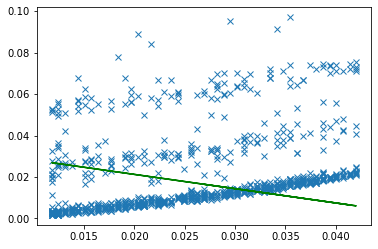

B0: [0.03506151], B1: [[-0.689587]]


In [17]:
beta1, beta0 = network.parameters()

beta0 = beta0.data.numpy()
beta1 = beta1.data.numpy()

yplot = X_train * beta1 + beta0
plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot.reshape(-1, 1), 'g')
plt.show()

print(f'B0: {beta0}, B1: {beta1}')

In [ ]:
with torch.no_grad():
    yhat = X_train * beta1 + beta0
    error = y_train - yhat

    plt.hist(error, bins=50)
    plt.show()

### Plot loss curve

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

# References

- https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
- https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
- Data was taken from: https://www.kaggle.com/mirichoi0218/insurance

# ToDo

- Sometimes model is not converging, how can I fix this?
- What is the difference between a model and nn.Linear? nn.Module is a neural network containers. Linear is a type of layer
- Check other parameters to tune in the model to improve model converging.

# Notes

Since data is very spread, using an small batch size the model doesn't seems to converge, if I use a bigger batch size, it does better.